# MDM imaging analysis

In [16]:
# load modules
from scipy.stats import stats
import scipy.io as spio
import nibabel as nib
import numpy as np
from matplotlib import pyplot as plt
import os
import glob
# from sklearn import preprocessing
# from sklearn.preprocessing import StandardScaler
from nilearn.input_data import NiftiMasker
import nilearn.plotting as plotting
from nilearn.image import mean_img
import pickle
import pandas as pd
import seaborn as sns 

%matplotlib inline 
%autosave 5
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})

Autosaving every 5 seconds


In [61]:
base_root = '/home/rj299/project/mdm_analysis/'
data_root = '/home/rj299/project/mdm_analysis/data_rename'
out_root = '/home/rj299/project/mdm_analysis/output'

# data_root = 'D:\Ruonan\Projects in the lab\MDM Project\Medical Decision Making Imaging\MDM_imaging\Imaging Analysis\data_rename'
# out_root = 'D:\Ruonan\Projects in the lab\MDM Project\Medical Decision Making Imaging\MDM_imaging\Imaging Analysis\output'

In [4]:
# get all subjects folder
sub_fold = glob.glob(data_root + '/sub-*')
# sub_fold = glob.glob(data_root + '\\sub-*')

# get all subject id
# sub_num = [] 
# for fold in sub_fold:
#     sub_id = fold.split('sub-')[1]
#     sub_num.append(int(sub_id))


# Subjects included in analysis
sub_num = [2073, 2550, 2582, 2583, 2584, 2585, 2588, 2592, 2593, 2594, 2596, 2597, 2598, 
           2600, 2624, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2662, 2663, 2664, 2665, 2666]

sub_num.sort()
print('All subjects included in analysis:', sub_num)

All subjects included in analysis: [2073, 2550, 2582, 2583, 2584, 2585, 2588, 2592, 2593, 2594, 2596, 2597, 2598, 2600, 2624, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2662, 2663, 2664, 2665, 2666]


## Rename task number to run number.

In [10]:
# functions for changing file names

# rename all files by adding run number determined by session and task number during scanning
def addRunNum(directory): 
    """ Add scan run numbers to file name
    
    Parameters
    --------------
    directory: directory for a subject, contains data for all runs
    
    """
    
    os.chdir(directory)
    
    # get sorted task number from the directory
    task_num_all = getTaskNum(directory)
    
    # add run number and rename
    for filename in os.listdir(directory):
        # get task number
        task_num = int(filename.split('_task-task')[1].split('_')[0])
        
        # get the run number based on all the task number in the directory
        run_count = task_num_all.index(task_num) + 1

        
        filename_new = filename.split('_task-task%s' %task_num)[0] + '_task-%s' %run_count + filename.split('_task-task%s' %task_num)[1]

        os.rename(filename, filename_new)  
        print(filename_new)

# get all task numbers for ses one
def getTaskNum(directory):
    """ Get all the task number for a session
     
    Parameters
    -----------------
    directory: data directory for a subject
    
    Return
    -----------------
    task_num: sorted task number for each session
    """
    file_ses = glob.glob('sub-*_ses-1_task*_bold.nii.gz')
    
    task_num = []
    
    for file in file_ses:
        task_id = file.split('_task-task')[1].split('_space')[0]
        task_num.append(int(task_id))
    
    task_num.sort()
    
    return task_num

The following two sections change the file names and only need running ONCE.

In [14]:
# sub_fold

In [13]:
# rename files and add run number in the file name
# needs running only ONCE
# sub_fold = ['/home/rj299/project/mdm_analysis/data_rename/sub-2654',
#             '/home/rj299/project/mdm_analysis/data_rename/sub-2658']

# for fold in sub_fold:
#     if fold != '/home/rj299/project/mdm_analysis/data_rename/sub-2582':
#         fold_func = os.path.join(fold, 'ses-1', 'func')
#         addRunNum(fold_func)

In [10]:
# rename files and add run number in the file name
# subject 2582 only, because the files are named in a different way
# rename all files by adding run number determined by session and task number during scanning

# run ONLY ONCE

# def addRunNum_2582(directory): 
#     """ Add scan run numbers to file name
    
#     Parameters
#     --------------
#     directory: directory for a subject, contains data for all runs
    
#     """
#     os.chdir(directory)
    
#     # get sorted task number from the directory
#     task_num_all = getTaskNum_2582(directory)
    
#     # add run number and rename
#     for filename in os.listdir(directory):
#         # get task number
#         task_num = int(filename.split('_task-')[1].split('_')[0])
        
#         # get the run number based on all the task number in the directory
#         run_count = task_num_all.index(task_num) + 1

        
#         filename_new = filename.split('_task-%s' %task_num)[0] + '_task-%s' %run_count + filename.split('_task-%s' %task_num)[1]

#         os.rename(filename, filename_new)  
#         print(filename_new)

# # get all task numbers for ses one
# def getTaskNum_2582(directory):
#     """ Get all the task number for a session
    
#     Parameters
#     -----------------
#     directory: data directory for a subject
    
#     Return
#     -----------------
#     task_num: sorted task number for each session
#     """
#     file_ses = glob.glob('sub-*_ses-1_task*_bold.nii.gz')
    
#     task_num = []
    
#     for file in file_ses:
#         task_id = file.split('_task-')[1].split('_space')[0]
#         task_num.append(int(task_id))
    
#     task_num.sort()
    
#     return task_num

# addRunNum_2582(os.path.join(data_root, 'sub-2582','ses-1','func'))

## Load anatomical data

In [8]:
def load_anat(sub):
    """ Load single subject anatomical data
    
    Parameters:
    ----------
    sub: subject id
    
    Retrun:
    ----------
    
    """
    
    anat_in = os.path.join(data_root, 'sub-%s' %sub, 'anat', 'sub-%s_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz' %sub)
    anat = nib.load(anat_in)
    
    return anat

In [17]:
# load all subjects' anatomical data
anat = []
for sub in sub_num:
    anat.append(load_anat(sub))

# average
anat_mean = mean_img(anat)

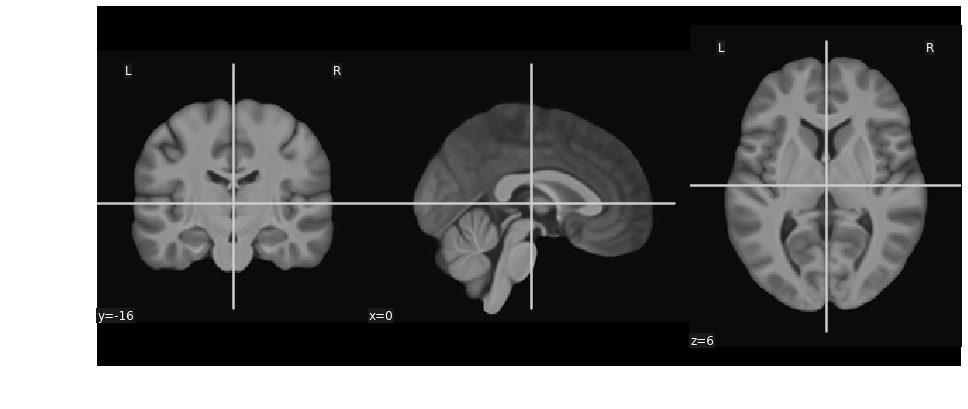

In [18]:
fig = plt.figure(figsize = (12,5))
plotting.plot_anat(anat_mean, black_bg = True, figure = fig)

In [20]:
# save the mean anatomical image
# anat_mean.to_filename(os.path.join(out_root, 'all_sub_average.nii.gz'))

3


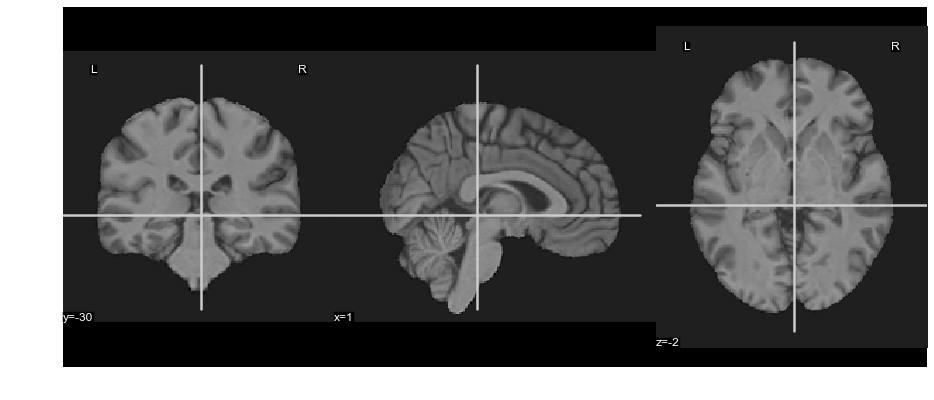

In [51]:
print(len(anat))

# single subject anatomical plot
fig = plt.figure(figsize = (12,5))
plotting.plot_anat(anat[0], black_bg = True, figure = fig)

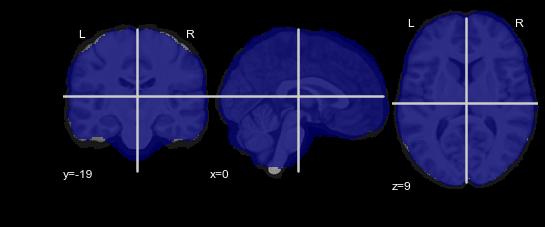

In [54]:
mask_whb = load_whb_mask(2073,2)
plotting.plot_roi(mask_whb, bg_img = anat_mean)

## Look at SPM level1 analysis output

In [64]:
con1 = nib.load(os.path.join(out_root, 'Sink', '1stLevel', '_subject_id_2588_task_id_1','con_0001.nii'))
con2 = nib.load(os.path.join(out_root, 'Sink', '1stLevel', '_subject_id_2588_task_id_1','con_0002.nii'))

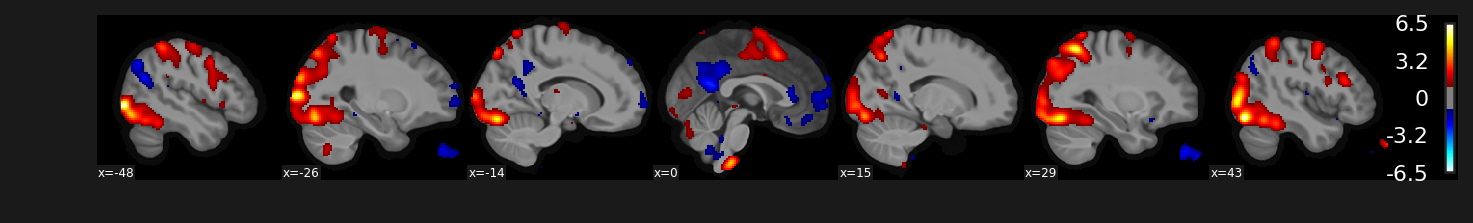

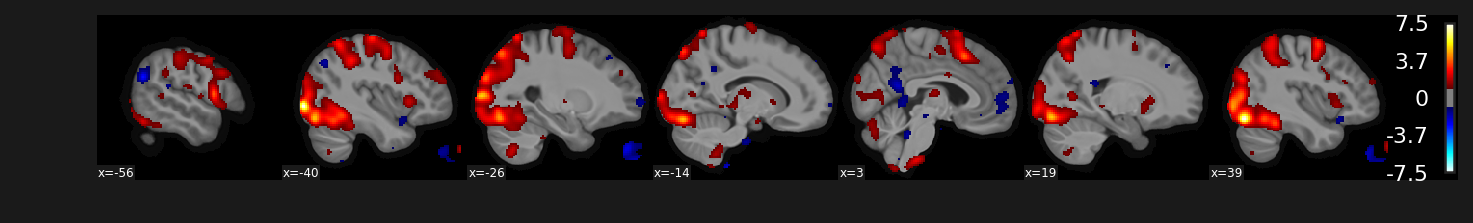

In [65]:
plotting.plot_stat_map(con1, threshold = 1, bg_img = anat_mean, display_mode = 'x')
plotting.plot_stat_map(con2, threshold = 1, bg_img = anat_mean, display_mode = 'x')

In [66]:
spmt1 = nib.load(os.path.join(out_root, 'Sink', '1stLevel', '_subject_id_2588_task_id_1','spmT_0001.nii'))
spmt2 = nib.load(os.path.join(out_root, 'Sink', '1stLevel', '_subject_id_2588_task_id_1','spmT_0002.nii'))

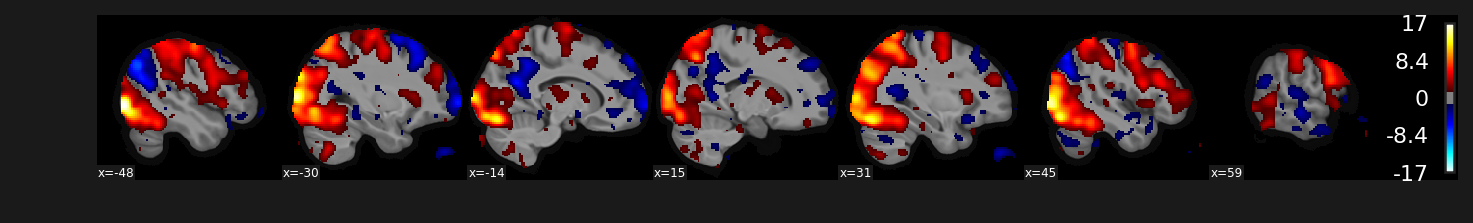

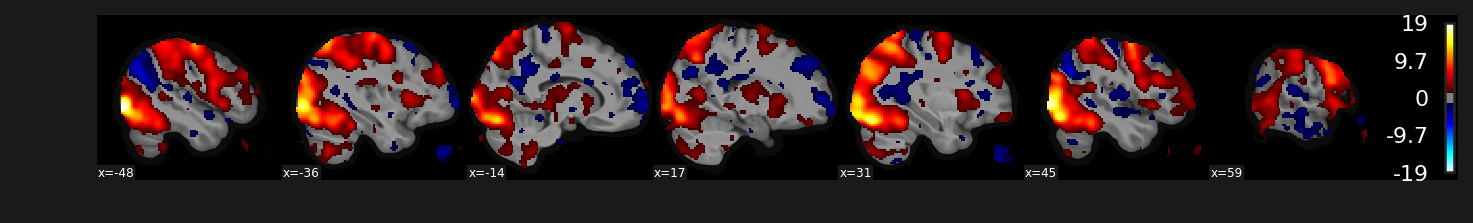

In [67]:
plotting.plot_stat_map(spmt1, threshold = 1.5, bg_img = anat_mean, display_mode = 'x')
plotting.plot_stat_map(spmt2, threshold = 1.5, bg_img = anat_mean, display_mode = 'x')

In [68]:
resid = nib.load('/home/rj299/project/mdm_analysis/work/l1spm/_subject_id_2588_task_id_1/level1estimate/ResMS.nii')

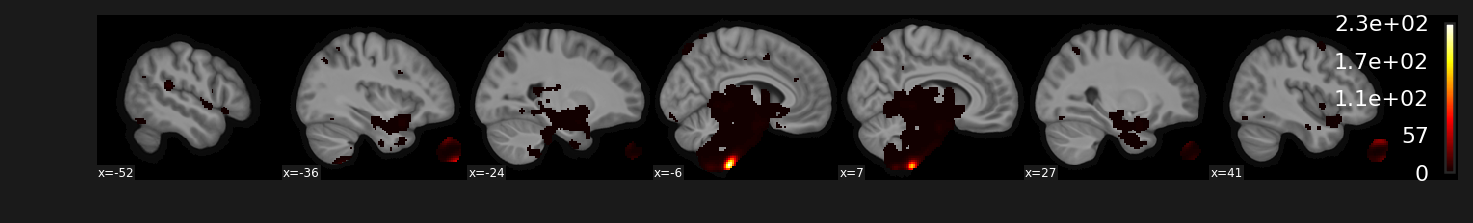

In [72]:
plotting.plot_stat_map(resid, threshold = 2, bg_img = anat_mean, display_mode = 'x')

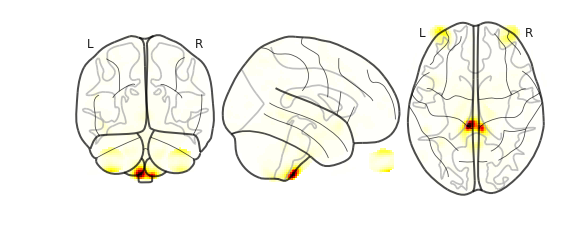

In [73]:
plotting.plot_glass_brain(resid)

In [74]:
con1.affine

array([[   2. ,    0. ,    0. ,  -96.5],
       [   0. ,    2. ,    0. , -132.5],
       [   0. ,    0. ,    2. ,  -78.5],
       [   0. ,    0. ,    0. ,    1. ]])

## Functional data and GLM
Ref: https://cogmaster-stats.github.io/python-cogstats/auto_examples/plot_auditory_analysis.html

Using nypipe: https://nipype.readthedocs.io/en/latest/users/examples/fmri_nipy_glm.html

Use Or's code

From nipype website examples

## Functional data and RSA

In [55]:
def load_epi_data(sub, task):
    """ Load a single run epi data for each subject
    
    Input:
    ----------
    sub: subject id, integer
    task: task id, integer
    
    Return:
    ----------
    epi_data
    
    """
    # Load MRI file (in Nifti format) of one localizer run
    epi_in = os.path.join(data_root, 'sub-%s' %sub, 'ses-1', 'func', 
              "sub-%s_ses-1_task-%s_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz" % (sub, task))
    epi_data = nib.load(epi_in)
    print("Loading data from %s" % (epi_in))
    return epi_data

In [53]:
def load_whb_mask(sub, task):
    """Load whole brain mask for a subject
    
    Parameters
    -----------
    sub: subject id
    task: task id
    
    Return
    -----------
    mask: loaded whole-brain data
    """
    
    maskfile = os.path.join(data_root, 'sub-%s' %sub, 'ses-1', 'func',
                            'sub-%s_ses-1_task-%s_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz' %(sub, task))
    mask = nib.load(maskfile)
    return mask

In [ ]:
def mask_data(epi_data, mask): 
    """mask the input data with the input mask 
    Parameters
    ----------
    epi_data: unmasked data
    mask: roi or whole brain mask
    
    Return
    ----------
    epi_masked_data: masked data
    """    
    
    nifti_masker = NiftiMasker(mask_img=mask)
    
    
    epi_masked_data = nifti_masker.fit_transform(epi_data);
    return epi_masked_data